In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import random

# Import quantization modules
import torch.quantization
from torch.quantization import QuantStub, DeQuantStub, fuse_modules
from torch.quantization.qconfig import QConfig
from torch.quantization import prepare_qat, convert

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

In [2]:
# Load CSV data into a DataFrame

data_path = "../data/data.csv"
columns = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 
           'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 
           'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 
           'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 
           'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 
           'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 
           'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 
           'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 
           'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'label']

df = pd.read_csv(data_path, header=None, names=columns)
print("Dataset shape:", df.shape)
df.head()
label_counts = df['label'].value_counts()
print(label_counts)


Dataset shape: (4898431, 42)
label
smurf.              2807886
neptune.            1072017
normal.              972781
satan.                15892
ipsweep.              12481
portsweep.            10413
nmap.                  2316
back.                  2203
warezclient.           1020
teardrop.               979
pod.                    264
guess_passwd.            53
buffer_overflow.         30
land.                    21
warezmaster.             20
imap.                    12
rootkit.                 10
loadmodule.               9
ftp_write.                8
multihop.                 7
phf.                      4
perl.                     3
spy.                      2
Name: count, dtype: int64


1. Preprocessing

Now I will classify two different type of data, categorical and continous. This is because each type of data have 
different way of encoding it. So we will encode it differently, then concat it to create a token that represent a row of
data.

In [3]:
categorical_cols = ['protocol_type', 'service', 'flag', 'land', 'logged_in', 'is_host_login', 'is_guest_login']
continuous_cols = [col for col in df.columns if col not in categorical_cols + ['label']]

In [4]:
#For continuous data, we will use normalisation 
scaler = StandardScaler()
df_cont = pd.DataFrame(scaler.fit_transform(df[continuous_cols]), columns=continuous_cols)

In [5]:
#For categorical data, since they r text, we will use label encoder
df_cat = df[categorical_cols].copy()
cat_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_cat[col] = le.fit_transform(df_cat[col].astype(str))
    cat_encoders[col] = le

In [6]:
#Preprocessing the label
# Process target labels: first remove trailing punctuation if any (e.g., "normal." -> "normal")
df['label'] = df['label'].str.replace(r'\W+$', '', regex=True)
target_labels = ['back', 'buffer_overflow', 'ftp_write', 'guess_passwd', 'imap', 'ipsweep', 'land', 
                 'loadmodule', 'multihop', 'neptune', 'nmap', 'normal', 'perl', 'phf', 'pod', 'portsweep', 
                 'rootkit', 'satan', 'smurf', 'spy', 'teardrop', 'warezclient', 'warezmaster']


In [7]:
# Create label encoder for targets
target_le = LabelEncoder()
target_le.fit(target_labels)
df['label_enc'] = target_le.transform(df['label'])
print(target_le.classes_)



['back' 'buffer_overflow' 'ftp_write' 'guess_passwd' 'imap' 'ipsweep'
 'land' 'loadmodule' 'multihop' 'neptune' 'nmap' 'normal' 'perl' 'phf'
 'pod' 'portsweep' 'rootkit' 'satan' 'smurf' 'spy' 'teardrop'
 'warezclient' 'warezmaster']


In [8]:
# Combine continuous and categorical features
df_features = pd.concat([df_cont, df_cat], axis=1)
print("Processed features shape:", df_features.shape)
df_features.head()

Processed features shape: (4898431, 41)


,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,root_shell,su_attempted,...,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,protocol_type,service,flag,land,logged_in,is_host_login,is_guest_login
0,-0.066833,-0.001720,0.068188,-0.015139,-0.001103,-0.026521,-0.004391,-0.002097,-0.008258,-0.004546,...,-0.465454,-0.250832,-0.249632,1,24,9,0,1,0,0
1,-0.066833,-0.001777,0.005325,-0.015139,-0.001103,-0.026521,-0.004391,-0.002097,-0.008258,-0.004546,...,-0.465454,-0.250832,-0.249632,1,24,9,0,1,0,0
2,-0.066833,-0.001698,0.000208,-0.015139,-0.001103,-0.026521,-0.004391,-0.002097,-0.008258,-0.004546,...,-0.465454,-0.250832,-0.249632,1,24,9,0,1,0,0
3,-0.066833,-0.001701,0.001455,-0.015139,-0.001103,-0.026521,-0.004391,-0.002097,-0.008258,-0.004546,...,-0.465454,-0.250832,-0.249632,1,24,9,0,1,0,0
4,-0.066833,-0.001695,-0.000942,-0.015139,-0.001103,-0.026521,-0.004391,-0.002097,-0.008258,-0.004546,...,-0.465454,-0.250832,-0.249632,1,24,9,0,1,0,0


2. Create the model

My intention is using a transformer that have similar structure to BERT. This is because the model will have an attention layer to learn the semantic relationship between packets. The sliding allows
use to look at a range of packets in sequence, and look if there is suspicious packets in the sequence.

In [9]:
WINDOW_SIZE = 100
class SlidingWindowDataset(Dataset):
    def __init__(self, features, labels, window_size):
        """
        features: numpy array of shape (num_rows, num_features)
        labels: numpy array of shape (num_rows,)
        window_size: int, number of rows per window
        """
        self.features = features
        self.labels = labels
        self.window_size = window_size
        self.num_samples = len(features) - window_size + 1  # number of sliding windows
        
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        # Extract a window of consecutive rows on the fly
        window = self.features[idx : idx + self.window_size]
        # For simplicity, we use the label of the last row in the window. It means that if there is a bad packet in the end of the sequence,
        #the model will immediately flag entire sequence as bad as soon as a bad packet comes in
        label = self.labels[idx + self.window_size - 1]
        return torch.tensor(window, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

# Get the preprocessed feature and label arrays
features_np = df_features.values.astype(np.float32)
labels_np = df['label_enc'].values.astype(np.int64)
print("Original features shape:", features_np.shape)
print("Original labels shape:", labels_np.shape)

# Create the sliding window dataset
dataset = SlidingWindowDataset(features_np, labels_np, WINDOW_SIZE)
print("Sliding window dataset length:", len(dataset))

# Split the dataset into training and test sets using random_split
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) #originally batch_size = 32
test_loader = DataLoader(test_dataset, batch_size=32)

Original features shape: (4898431, 41)
Original labels shape: (4898431,)
Sliding window dataset length: 4898332


In [10]:
# class PacketTransformer(nn.Module):
#     def __init__(self, input_dim, embed_dim, num_layers, num_heads, window_size, num_classes):
#         super(PacketTransformer, self).__init__()
#         self.window_size = window_size
        
#         # Project the input token (each row) into an embedding
#         self.input_proj = nn.Linear(input_dim, embed_dim)
        
#         # [CLS] token embedding (learnable)
#         self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        
#         # Positional embeddings: one per token in the window (+1 for [CLS])
#         self.pos_embedding = nn.Parameter(torch.randn(window_size + 1, embed_dim))
        
#         # Transformer encoder layers
#         encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dropout=0.1)
#         self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
#         # Classification head
#         self.classifier = nn.Sequential(
#             nn.Linear(embed_dim, embed_dim),
#             nn.ReLU(),
#             nn.Linear(embed_dim, num_classes)
#         )
        
#     def forward(self, x):
#         """
#         x: tensor of shape [batch, window_size, input_dim]
#         """
#         batch_size = x.size(0)
#         # Project each token
#         tokens = self.input_proj(x)  # [batch, window_size, embed_dim]
        
#         # Prepend [CLS] token for each sample in the batch
#         cls_tokens = self.cls_token.expand(batch_size, -1, -1)  # [batch, 1, embed_dim]
#         tokens = torch.cat([cls_tokens, tokens], dim=1)  # [batch, window_size+1, embed_dim]
        
#         # Add positional embedding
#         tokens = tokens + self.pos_embedding.unsqueeze(0)
        
#         # Transformer expects shape: [seq_len, batch, embed_dim]
#         tokens = tokens.transpose(0, 1)
#         transformer_out = self.transformer_encoder(tokens)
        
#         # Use [CLS] token output for classification (first token)
#         cls_out = transformer_out[0]  # [batch, embed_dim]
#         logits = self.classifier(cls_out)
#         return logits

In [11]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, num_layers):
        super(TransformerBlock, self).__init__()
        
        # Create transformer with batch_first=True for easier handling
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, 
            nhead=num_heads, 
            dropout=0.1, 
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
    
    def forward(self, x):
        return self.transformer_encoder(x)

In [12]:
class QuantizablePacketTransformer(nn.Module):
    def __init__(self, input_dim, embed_dim, num_layers, num_heads, window_size, num_classes):
        super(QuantizablePacketTransformer, self).__init__()
        self.window_size = window_size
        
        # Quantization stubs
        self.quant = QuantStub()
        self.dequant = DeQuantStub()
        
        # Input projection - will be quantized
        self.input_proj = nn.Linear(input_dim, embed_dim)
        
        # Parameters - will not be quantized
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.pos_embedding = nn.Parameter(torch.randn(window_size + 1, embed_dim))
        
        # Transformer block - will not be quantized
        self.transformer_block = TransformerBlock(embed_dim, num_heads, num_layers)
        
        # Classification head - will be quantized
        self.fc1 = nn.Linear(embed_dim, embed_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(embed_dim, num_classes)
        
    def forward(self, x):
        # Quantize input
        x = self.quant(x)
        
        # Process input projection (quantized)
        batch_size = x.size(0)
        tokens = self.input_proj(x)  # [batch, window_size, embed_dim]
        
        # Dequantize before non-quantizable operations
        tokens = self.dequant(tokens)
        
        # Non-quantized operations
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        tokens = torch.cat([cls_tokens, tokens], dim=1)
        tokens = tokens + self.pos_embedding.unsqueeze(0)
        
        # Pass through transformer (non-quantized)
        transformer_out = self.transformer_block(tokens)
        cls_out = transformer_out[:, 0, :]  # Get CLS token output
        
        # Requantize for classification head
        cls_out = self.quant(cls_out)
        
        # Classification head (quantized)
        x = self.fc1(cls_out)
        x = self.relu(x)
        logits = self.fc2(x)
        
        # Final dequantization
        logits = self.dequant(logits)
        return logits
    
    def fuse_model(self):
        """Fuse operations for better quantization performance"""
        try:
            # Try both import paths for compatibility with different PyTorch versions
            try:
                from torch.quantization import fuse_modules
            except ImportError:
                from torch.ao.quantization import fuse_modules
            
            fuse_modules(self, ['fc1', 'relu'], inplace=True)
            print("Fusion successful")
        except Exception as e:
            print(f"Fusion failed: {e}. Continuing without fusion.")
    
    def set_qconfig(self):
        """Custom qconfig setup that excludes transformer layers"""
        qconfig = torch.quantization.get_default_qat_qconfig('fbgemm')
        
        # Set qconfig for the whole model
        self.qconfig = qconfig
        
        # Remove qconfig from transformer block (it doesn't support quantization well)
        self.transformer_block.qconfig = None
        
        # Make sure parameters inside transformer are also without qconfig
        for module in self.transformer_block.modules():
            module.qconfig = None


In [13]:
def prepare_model_for_qat(model, device):
    # Step 1: Start with model on CPU
    model = model.cpu()
    
    # Step 2: Fuse layers where possible
    model.fuse_model()
    
    # Step 3: Set quantization backend
    torch.backends.quantized.engine = 'fbgemm'  # Use 'qnnpack' for ARM processors
    
    # Step 4: Configure which parts to quantize
    qconfig = torch.quantization.get_default_qat_qconfig('fbgemm')
    
    # Default configuration for the model
    model.qconfig = qconfig
    
    # Explicitly exclude transformer and parameters from quantization
    model.transformer_block.qconfig = None
    for module in model.transformer_block.modules():
        module.qconfig = None
    
    # Step 5: Prepare the model for QAT
    try:
        torch.quantization.prepare_qat(model, inplace=True)
        print("QAT preparation successful")
    except Exception as e:
        print(f"QAT preparation failed: {e}")
        
    # Step 6: Move to the training device
    return model.to(device)

# Initialize and prepare the model
input_dim = dataset.features.shape[-1]
embed_dim = 16 #16
num_layers = 1
num_heads = 2
num_classes = len(target_labels)
num_epochs = 60

device = torch.device("cpu")
print("Using device:", device)

# Create the model
model = QuantizablePacketTransformer(
    input_dim=input_dim, 
    embed_dim=embed_dim, 
    num_layers=num_layers,
    num_heads=num_heads, 
    window_size=WINDOW_SIZE, 
    num_classes=num_classes
)

Using device: cpu


In [14]:
model = prepare_model_for_qat(model, device)

# Set up training
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-6) #1e-3

Fusion successful
QAT preparation successful


c:\Users\Antoi\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\ao\quantization\observer.py:229: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


In [15]:
# def train_epoch(model, loader, criterion, optimizer, device):
#     model.train()
#     running_loss = 0.0
#     # Wrap loader with tqdm for progress bar
#     for batch_X, batch_y in tqdm(loader, desc="Training", leave=False):
#         batch_X, batch_y = batch_X.to(device), batch_y.to(device)
#         optimizer.zero_grad()
#         logits = model(batch_X)
#         loss = criterion(logits, batch_y)
#         loss.backward()
#         optimizer.step()
#         running_loss += loss.item() * batch_X.size(0)
#     return running_loss / len(loader.dataset)

In [16]:
def train_with_qat(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    processed_batches = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        # Move data to the correct device
        data, target = data.to(device), target.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        output = model(data)
        loss = criterion(output, target)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Accumulate loss (make sure to use .item() to get the scalar value)
        total_loss += loss.item()
        processed_batches += 1
        
        # Print progress
        # if batch_idx % 10 == 0:
        #     print(f'Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}')
    
    # Return average loss
    return total_loss / processed_batches if processed_batches > 0 else 0.0

In [17]:
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    all_preds = []
    all_labels = []
    
    # Wrap loader with tqdm for progress bar during evaluation
    for batch_X, batch_y in tqdm(loader, desc="Evaluating", leave=False):
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        logits = model(batch_X)
        loss = criterion(logits, batch_y)
        running_loss += loss.item() * batch_X.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == batch_y).sum().item()
        # Collect predictions and true labels for confusion matrix
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())
        
    avg_loss = running_loss / len(loader.dataset)
    avg_acc = correct / len(loader.dataset)
    return avg_loss, avg_acc, all_labels, all_preds

In [18]:
for epoch in range(1, num_epochs+1):
    print(f"Epoch {epoch}/{num_epochs}")
    train_loss = train_with_qat(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, all_labels, all_preds = evaluate(model, test_loader, criterion, device)

    
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

Epoch 1/60


Train Loss: 1.1971 | Val Loss: 0.2251 | Val Acc: 0.9891
Epoch 2/60


Train Loss: 0.0929 | Val Loss: 0.0443 | Val Acc: 0.9901
Epoch 3/60


Train Loss: 0.0406 | Val Loss: 0.0345 | Val Acc: 0.9901
Epoch 4/60


Train Loss: 0.0333 | Val Loss: 0.0291 | Val Acc: 0.9914
Epoch 5/60


Train Loss: 0.0286 | Val Loss: 0.0255 | Val Acc: 0.9932
Epoch 6/60


Train Loss: 0.0253 | Val Loss: 0.0227 | Val Acc: 0.9933
Epoch 7/60


Train Loss: 0.0231 | Val Loss: 0.0207 | Val Acc: 0.9944
Epoch 8/60


Train Loss: 0.0214 | Val Loss: 0.0193 | Val Acc: 0.9945
Epoch 9/60


Train Loss: 0.0200 | Val Loss: 0.0180 | Val Acc: 0.9951
Epoch 10/60


Train Loss: 0.0188 | Val Loss: 0.0168 | Val Acc: 0.9958
Epoch 11/60


Train Loss: 0.0177 | Val Loss: 0.0157 | Val Acc: 0.9962
Epoch 12/60


Train Loss: 0.0167 | Val Loss: 0.0147 | Val Acc: 0.9963
Epoch 13/60


Train Loss: 0.0158 | Val Loss: 0.0140 | Val Acc: 0.9965
Epoch 14/60


Train Loss: 0.0150 | Val Loss: 0.0131 | Val Acc: 0.9967
Epoch 15/60


Train Loss: 0.0142 | Val Loss: 0.0124 | Val Acc: 0.9968
Epoch 16/60


Train Loss: 0.0135 | Val Loss: 0.0115 | Val Acc: 0.9971
Epoch 17/60


Train Loss: 0.0128 | Val Loss: 0.0109 | Val Acc: 0.9973
Epoch 18/60


Train Loss: 0.0121 | Val Loss: 0.0104 | Val Acc: 0.9974
Epoch 19/60


Train Loss: 0.0116 | Val Loss: 0.0099 | Val Acc: 0.9976
Epoch 20/60


Train Loss: 0.0111 | Val Loss: 0.0095 | Val Acc: 0.9978
Epoch 21/60


Train Loss: 0.0106 | Val Loss: 0.0091 | Val Acc: 0.9980
Epoch 22/60


Train Loss: 0.0103 | Val Loss: 0.0088 | Val Acc: 0.9981
Epoch 23/60


Train Loss: 0.0098 | Val Loss: 0.0085 | Val Acc: 0.9982
Epoch 24/60


Train Loss: 0.0095 | Val Loss: 0.0082 | Val Acc: 0.9983
Epoch 25/60


Train Loss: 0.0092 | Val Loss: 0.0078 | Val Acc: 0.9984
Epoch 26/60


Train Loss: 0.0088 | Val Loss: 0.0076 | Val Acc: 0.9984
Epoch 27/60


Train Loss: 0.0086 | Val Loss: 0.0073 | Val Acc: 0.9985
Epoch 28/60


Train Loss: 0.0083 | Val Loss: 0.0070 | Val Acc: 0.9985
Epoch 29/60


Train Loss: 0.0080 | Val Loss: 0.0068 | Val Acc: 0.9985
Epoch 30/60


Train Loss: 0.0078 | Val Loss: 0.0066 | Val Acc: 0.9986
Epoch 31/60


Train Loss: 0.0074 | Val Loss: 0.0064 | Val Acc: 0.9986
Epoch 32/60


Train Loss: 0.0073 | Val Loss: 0.0062 | Val Acc: 0.9986
Epoch 33/60


Train Loss: 0.0070 | Val Loss: 0.0060 | Val Acc: 0.9987
Epoch 34/60


Train Loss: 0.0068 | Val Loss: 0.0058 | Val Acc: 0.9988
Epoch 35/60


Train Loss: 0.0067 | Val Loss: 0.0057 | Val Acc: 0.9989
Epoch 36/60


Train Loss: 0.0065 | Val Loss: 0.0055 | Val Acc: 0.9989
Epoch 37/60


Train Loss: 0.0064 | Val Loss: 0.0054 | Val Acc: 0.9989
Epoch 38/60


Train Loss: 0.0063 | Val Loss: 0.0053 | Val Acc: 0.9989
Epoch 39/60


Train Loss: 0.0061 | Val Loss: 0.0052 | Val Acc: 0.9989
Epoch 40/60


Train Loss: 0.0060 | Val Loss: 0.0051 | Val Acc: 0.9990
Epoch 41/60


Train Loss: 0.0059 | Val Loss: 0.0050 | Val Acc: 0.9990
Epoch 42/60


Train Loss: 0.0058 | Val Loss: 0.0049 | Val Acc: 0.9990
Epoch 43/60


Train Loss: 0.0057 | Val Loss: 0.0048 | Val Acc: 0.9990
Epoch 44/60


Train Loss: 0.0057 | Val Loss: 0.0048 | Val Acc: 0.9990
Epoch 45/60


Train Loss: 0.0056 | Val Loss: 0.0047 | Val Acc: 0.9990
Epoch 46/60


Train Loss: 0.0056 | Val Loss: 0.0046 | Val Acc: 0.9990
Epoch 47/60


Train Loss: 0.0054 | Val Loss: 0.0046 | Val Acc: 0.9990
Epoch 48/60


Train Loss: 0.0054 | Val Loss: 0.0045 | Val Acc: 0.9990
Epoch 49/60


Train Loss: 0.0053 | Val Loss: 0.0044 | Val Acc: 0.9990
Epoch 50/60


Train Loss: 0.0052 | Val Loss: 0.0043 | Val Acc: 0.9990
Epoch 51/60


Train Loss: 0.0052 | Val Loss: 0.0043 | Val Acc: 0.9990
Epoch 52/60


Train Loss: 0.0051 | Val Loss: 0.0042 | Val Acc: 0.9990
Epoch 53/60


Train Loss: 0.0051 | Val Loss: 0.0042 | Val Acc: 0.9990
Epoch 54/60


Train Loss: 0.0050 | Val Loss: 0.0041 | Val Acc: 0.9991
Epoch 55/60


Train Loss: 0.0049 | Val Loss: 0.0041 | Val Acc: 0.9991
Epoch 56/60


Train Loss: 0.0049 | Val Loss: 0.0040 | Val Acc: 0.9991
Epoch 57/60


Train Loss: 0.0048 | Val Loss: 0.0040 | Val Acc: 0.9992
Epoch 58/60


Train Loss: 0.0048 | Val Loss: 0.0039 | Val Acc: 0.9992
Epoch 59/60


Train Loss: 0.0047 | Val Loss: 0.0039 | Val Acc: 0.9992
Epoch 60/60


Train Loss: 0.0047 | Val Loss: 0.0039 | Val Acc: 0.9992


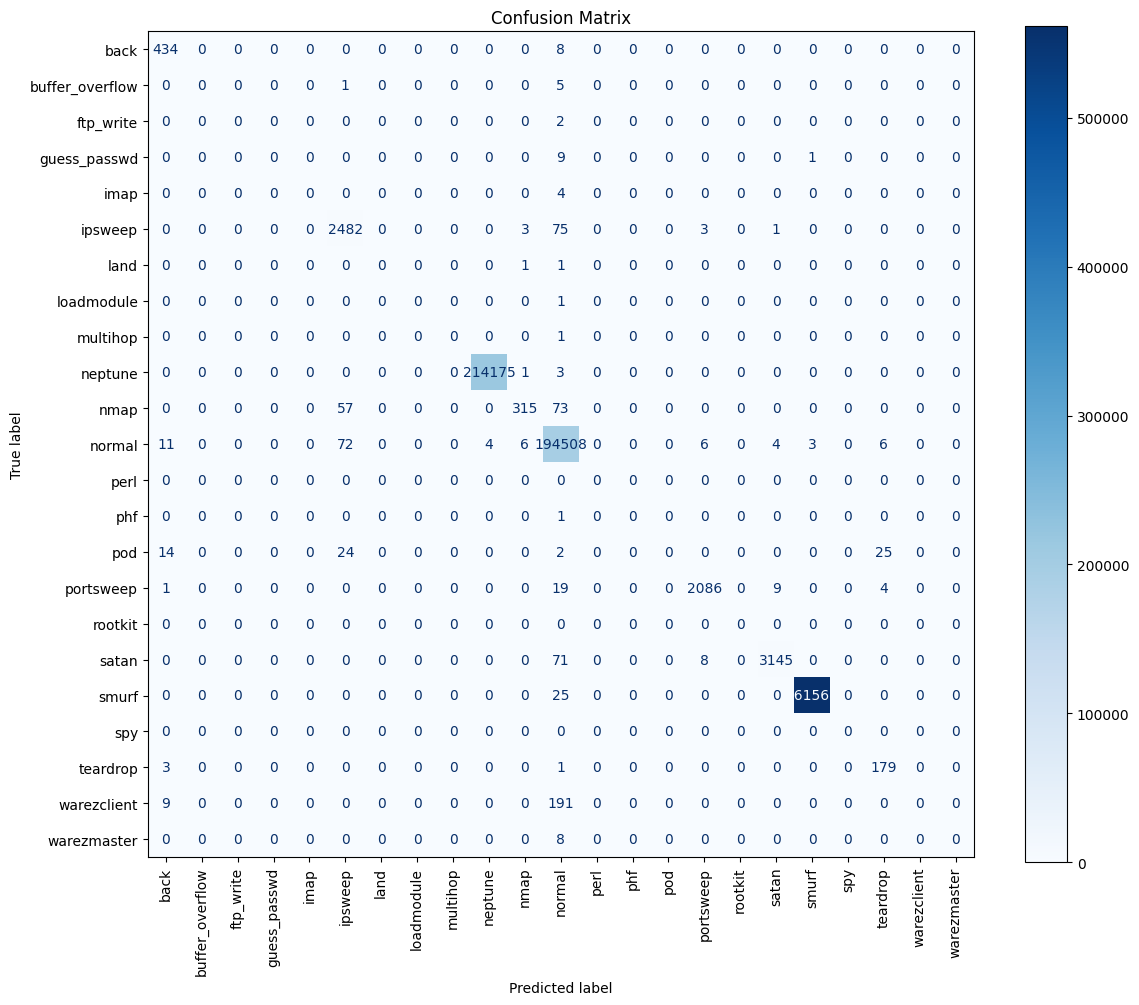

In [19]:
#colour scale is currently a bit strange

def compute_confusion_matrix(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch_X, batch_y in loader:
            batch_X = batch_X.to(device)
            logits = model(batch_X)
            preds = logits.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(batch_y.cpu().numpy())
    return all_labels, all_preds

# Compute confusion matrix on test data
true_labels, pred_labels = compute_confusion_matrix(model, test_loader, device)
cm = confusion_matrix(all_labels, all_preds, labels=list(range(len(target_labels))))

# Create a larger figure
fig, ax = plt.subplots(figsize=(12, 10))  

# Pass 'ax=ax' to plot the confusion matrix on this figure
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_labels)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical', ax=ax)

plt.title("Confusion Matrix")
plt.tight_layout()  # Helps reduce label overlap
plt.show()

In [20]:
model_quantised = torch.quantization.convert(model.cpu())

# Save or use the quantized model
torch.save(model_quantised.state_dict(), "quantised_model.pth")